In [9]:
import sys
sys.path.append('/mnt/Work/LaGonaveFM/') # or use path '/home/aesgeorges/LaGonaveFM/scripts/'
from codebase.figures import *
from codebase.tools import *

import cmocean
import numpy as np
import netCDF4 as netcdf
import matplotlib.pyplot as plt
from tqdm import tqdm
from kalpana.plotting import plot_nc
from kalpana.export import fort14togdf
from kalpana.ADCIRC_tools import extract_ts_from_nc
import cartopy.crs as ccrs
import matplotlib as mpl

In [10]:
xs = [-74.2, -73.5, -72.9, -72.8]
ys = [19.3133, 19.3133, 19.3133, 19.3133]

Remember that you had to edit the Kalpana source code for this extract_ts_from_nc to work with those files (adding extra split for ! NCD present in file). Remember to put in a pull request.

## ADCIRC+SWAN Run

In [11]:
timestep=43

In [12]:
super_shift = '../sims/Matthew16_base/'
root_swan = super_shift#+'adcirc+swan/'

In [13]:
## load the NetCDF dataset from a specified file path
nc_swan = netcdf.Dataset(root_swan+'fort.63.nc', 'r')
nc2 = netcdf.Dataset(root_swan+'fort.74.nc', 'r')

Map of transects for analysis

(<Figure size 1000x800 with 1 Axes>, <GeoAxesSubplot: >)

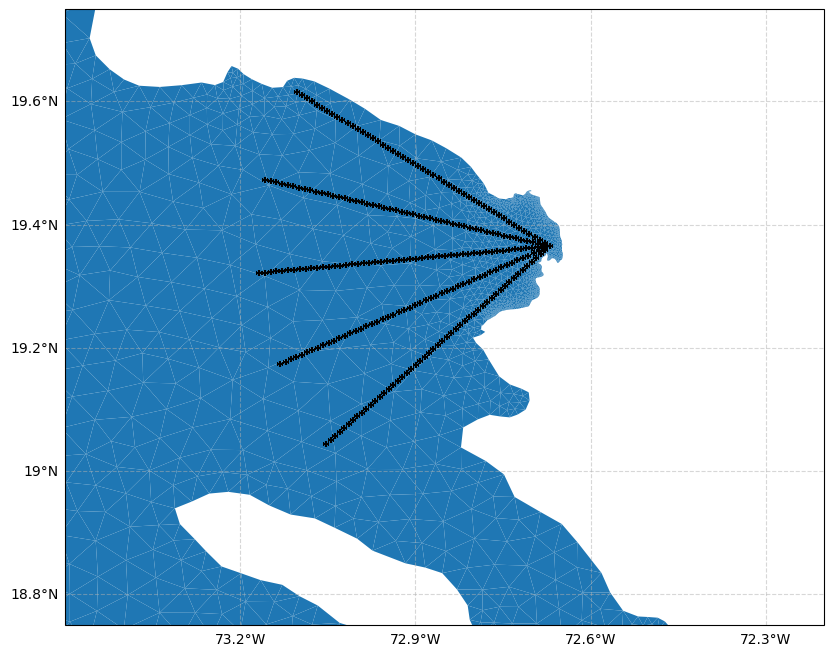

In [14]:
# Defining center of radius for arcs of observation stations
# Center is at the general midpoint of the mangrove forest in the open intertidal zone behind it.
center_x, center_y = -72.67, 19.365  

# List of radii (in NW increments) for the arcs of observation stations
radii = np.arange(0.5, 0., -0.01)  # Set distance between points to 0.05

# Define the start and end angles of the arc (in degrees)
start_angle = 150  # Starting angle of the arc
end_angle = 220  # Ending angle of the arc
num_points = 5

# Generate angles for the points along the arc
angles = np.linspace(np.radians(start_angle), np.radians(end_angle), num_points)

transects = []
for i in range(num_points):
    transects.append(make_transect(radii, angles[i], center_x, center_y))

mesh = fort14togdf(root_swan+'/fort.14', epsgIn=4326, epsgOut=4326, fileintype='fort.14')

plot_transects(mesh, center_x, center_y, num_points, transects)

Text(0.5, 1.0, 'ADCIRC+SWAN - fort.63.nc at timestep: 43')

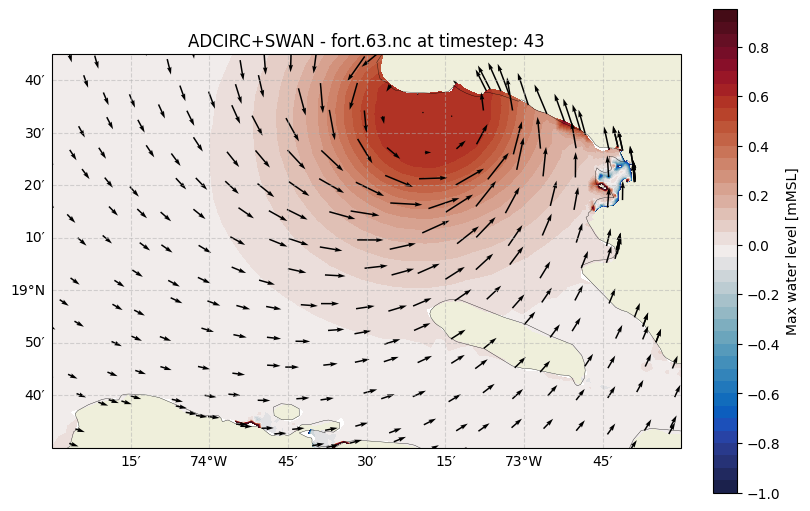

In [15]:
fig, ax = plt.subplots(figsize = (8,5), subplot_kw={'projection': ccrs.PlateCarree()}, 
                    constrained_layout=True)
plot_nc(nc_swan, 'zeta', levels = np.arange(-1., 1., 0.05), background_map = True, cbar = True, cb_label = 'Max water level [mMSL]', cmap = cmocean.cm.balance, ts = timestep,
        ncvec = nc2, dxvec=0.1, dyvec=0.1, vecsc=1000, ax = ax, fig = fig)
ax.set_xlim(-74.5, -72.5)
ax.set_ylim(18.5, 19.75)
ax.set_title('ADCIRC+SWAN - fort.63.nc at timestep: '+str(timestep))

(<Figure size 1000x600 with 2 Axes>,
 <AxesSubplot: title={'center': 'Water elevation along transect at 2016-10-04 20:00:00+00:00'}, xlabel='Longitude along transect', ylabel='Water Elevation'>,
 <GeoAxes: >)

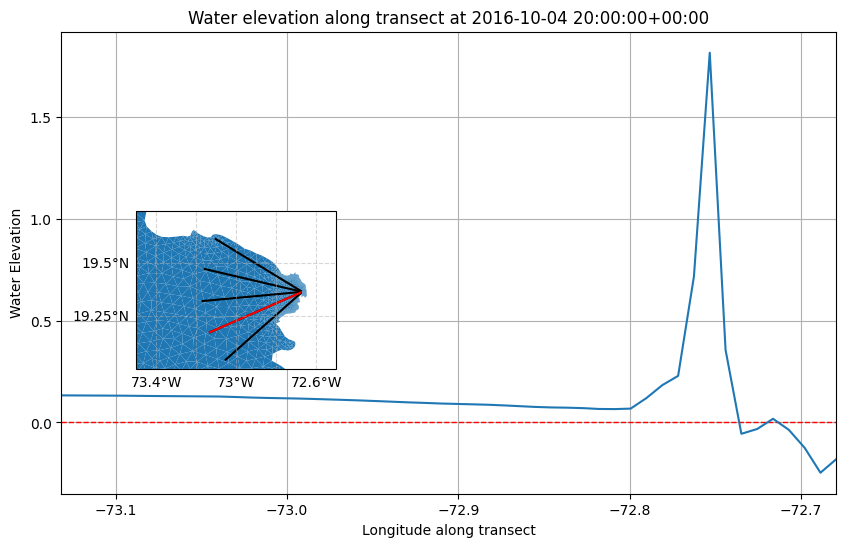

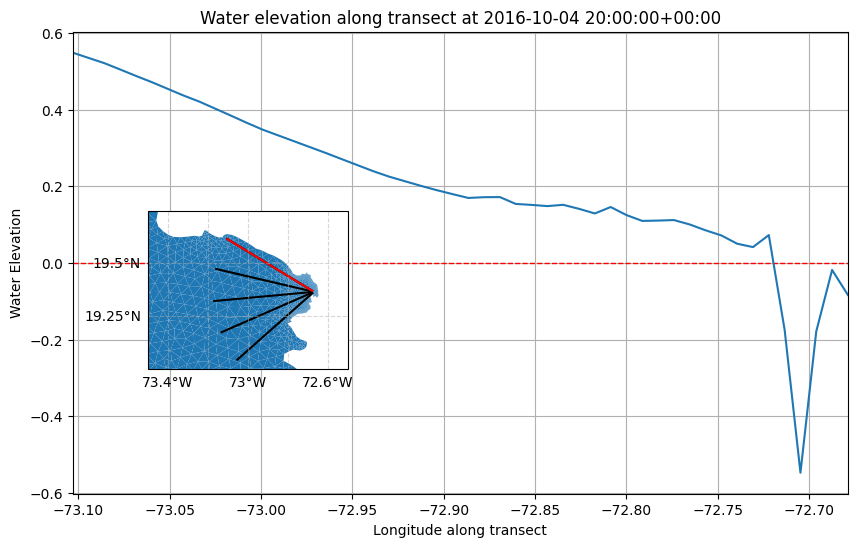

In [16]:
plot_transect_data(3, timestep, transects, nc_swan, mesh)
plot_transect_data(0, timestep, transects, nc_swan, mesh)

In [17]:
nc_HS = netcdf.Dataset(root_swan+'swan_HS.63.nc', 'r')

variables = list(nc_HS.variables.keys())
swan_HS_list = nc_HS.variables['swan_HS'][:]
print('Min: ' + str(swan_HS_list.min()))
print('Avg: ' + str(swan_HS_list.mean()))
print('Max: ' + str(swan_HS_list.max()))

Min: 1.5191132658457257e-18
Avg: 2.4578192255245837
Max: 16.112295150756836


<GeoAxesSubplot: xlabel='Longitude [deg]', ylabel='Latitude [deg]'>

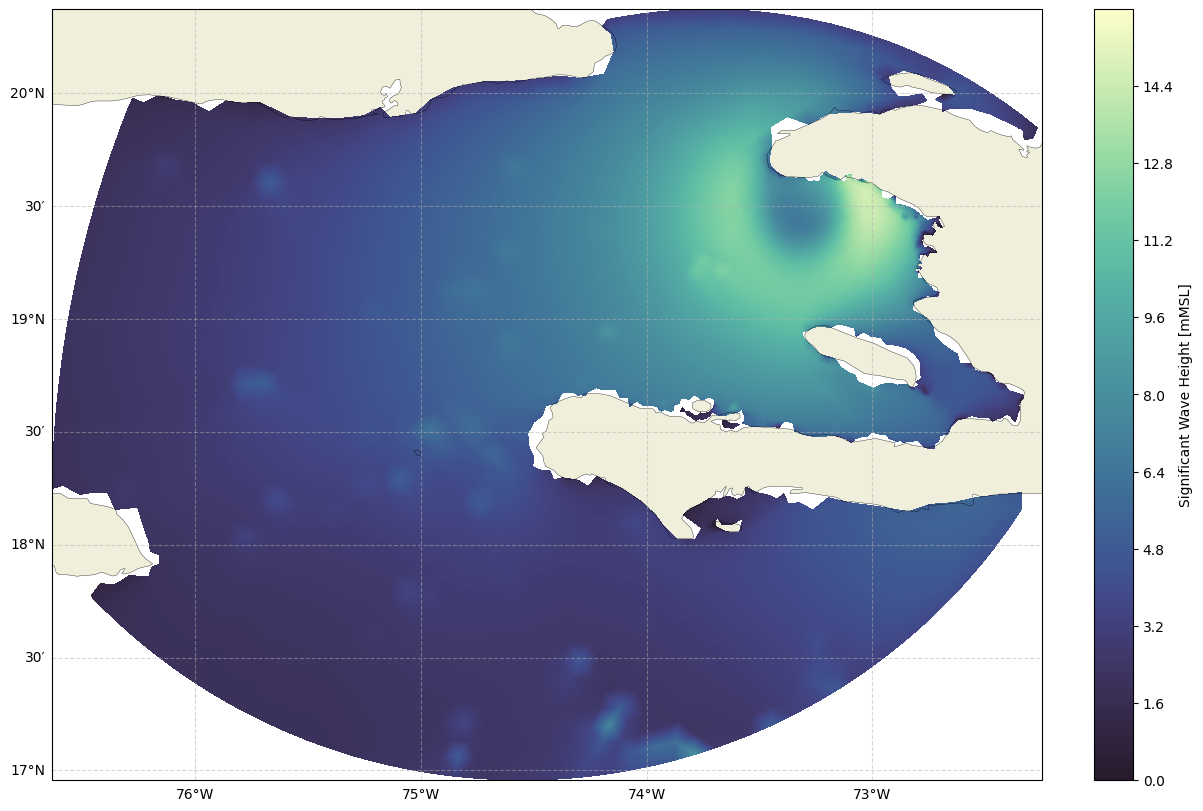

In [18]:
fig, ax = plt.subplots(figsize = (12,8), subplot_kw={'projection': ccrs.PlateCarree()}, 
                    constrained_layout=True)

plot_nc(nc_HS, 'swan_HS', levels = np.arange(0., 16., 0.01),
        background_map = True, cbar = True, cb_label = 'Significant Wave Height [mMSL]',
        cmap = cmocean.cm.deep_r, ts = timestep, ax = ax, fig = fig)

In [19]:
nc_DIR = netcdf.Dataset(root_swan+'swan_DIR.63.nc', 'r')
variables = list(nc_DIR.variables.keys())
swan_HS_DIR = nc_HS.variables['swan_HS'][:]
print('Min: ' + str(swan_HS_DIR.min()))
print('Avg: ' + str(swan_HS_DIR.mean()))
print('Max: ' + str(swan_HS_DIR.max()))

Min: 1.5191132658457257e-18
Avg: 2.4578192255245837
Max: 16.112295150756836


(<Figure size 1200x800 with 2 Axes>,
 <GeoAxesSubplot: title={'center': 'Wave Direction (arrows) and Height at timestep: 43'}, xlabel='Longitude [deg]', ylabel='Latitude [deg]'>)

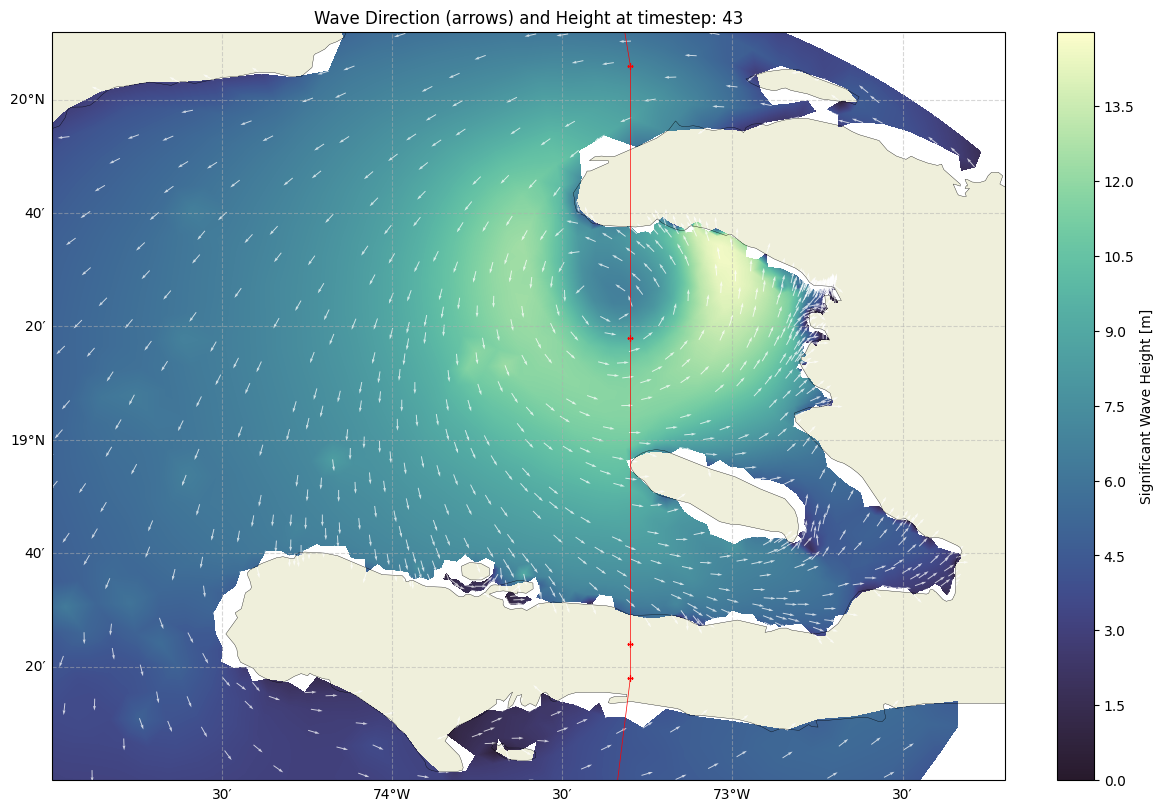

In [20]:
track_df = get_hurricane_track(root_swan + "fort.22")
plot_wave_direction_and_height(nc_HS, nc_DIR, track_df, timestep)

## Animation

In [31]:
from matplotlib.animation import FuncAnimation

In [ ]:
data = nc_HS #nc_swan  
var = 'swan_HS' #'zeta'#'swan_HS' 

for i in tqdm(range(47), desc="Generating frames"):
        fig, ax = plt.subplots(figsize = (8,5), subplot_kw={'projection': ccrs.PlateCarree()}, 
                                        constrained_layout=True)
        timestep=i
        # significant wave height
        plot_nc(nc_HS, 'swan_HS', levels = np.arange(0., 15., 0.01),
                background_map = True, cbar = True, cb_label = 'Significant Wave Height [m]',
                cmap = cmocean.cm.deep_r, ts = timestep, ax = ax, fig = fig)

        # Get the coordinates and wave direction data
        x = nc_DIR.variables['x'][:]
        y = nc_DIR.variables['y'][:]
        dir_data = nc_DIR.variables['swan_DIR'][timestep, :]

        # Convert from oceanographic convention (where waves come from) to mathematical (where arrows point)
        # In oceanographic convention, 0° is from North, 90° is from East
        # For plotting arrows, we need to convert to mathematical angles where 0° is East and goes counterclockwise
        #math_angles = (270 - dir_data) % 360
        math_angles_rad = np.radians(dir_data)

        # Calculate u and v components for arrows
        u = np.cos(math_angles_rad)
        v = np.sin(math_angles_rad)

        # Skip points to make the plot clearer - show arrows at every nth point
        n = 2
        ax.quiver(x[::n], y[::n], u[::n], v[::n], 
                        scale=80, width=0.001, color='white', 
                        alpha=0.65,
                        transform=ccrs.PlateCarree())

        # Plot trajectory line
        ax.plot(track_df['Longitude'], track_df['Latitude'], '+-', linewidth=0.5, color='red', markersize=5)

        # Plot points at each time step
        ax.set_xlim(-75., -72.2)
        ax.set_ylim(18., 20.2)

        ax.set_title('Wave Direction (arrows) and Height at timestep: '+str(timestep))





        """n = plot_nc(data, var, 
                levels = np.arange(0, 15., 0.05), 
                background_map = True, 
                cbar = True, 
                cb_label = 'Max water level [mMSL]', 
                cmap = cmocean.cm.balance, 
                ts = i,  # Use frame as timestep
                xlims=xlims, 
                ylims=ylims,
                ncvec = nc2, 
                dxvec=0.05, 
                dyvec=0.05, 
                vecsc=700)  # Pass the axis to plot on"""
        
        # Add frame number for reference
        #n.set_title(f'Timestep {i}')
        #fig = n.figure
        # Save the frame
        frame_file = f'animation/ts_{i}.png'
        fig.savefig(frame_file, dpi=500, bbox_inches='tight')
        plt.close(fig)

Generating frames: 100%|██████████| 47/47 [01:29<00:00,  1.91s/it]


In [ ]:
import imageio
import os

title = 'ADCIRC+SWAN_HS+DIR_shifted_small.gif' #ADCIRC+SWAN_HS.gif'

def create_animation_with_imageio():
    print("Creating animation with imageio...")
    
    # Get all frame files
    frames = []
    for ts in range(47):
        frame_file = f'animation/ts_{ts}.png'
        if os.path.exists(frame_file):
            frames.append(frame_file)
        else:
            print(f"Warning: File {frame_file} does not exist!")
    
    if not frames:
        print("No frames found!")
        return
    
    print(f"Found {len(frames)} frames")
    
    # Create GIF
    images = []
    for frame in frames:
        try:
            images.append(imageio.imread(frame))
        except Exception as e:
            print(f"Error reading {frame}: {str(e)}")
    
    if images:
        print(f"Creating GIF with {len(images)} images")
        imageio.mimsave('exports/'+title, images, fps=12, loop=0)
        print("Animation saved to exports/" + title)
    else:
        print("No images could be loaded")

# Try the alternative method
try:
    import imageio
    create_animation_with_imageio()
except ImportError:
    print("imageio not installed. Try: pip install imageio")

Creating animation with imageio...
Found 47 frames
Creating GIF with 47 images
Animation saved to ADCIRC+SWAN_HS+DIR_shifted_small.gif


## Station Locations

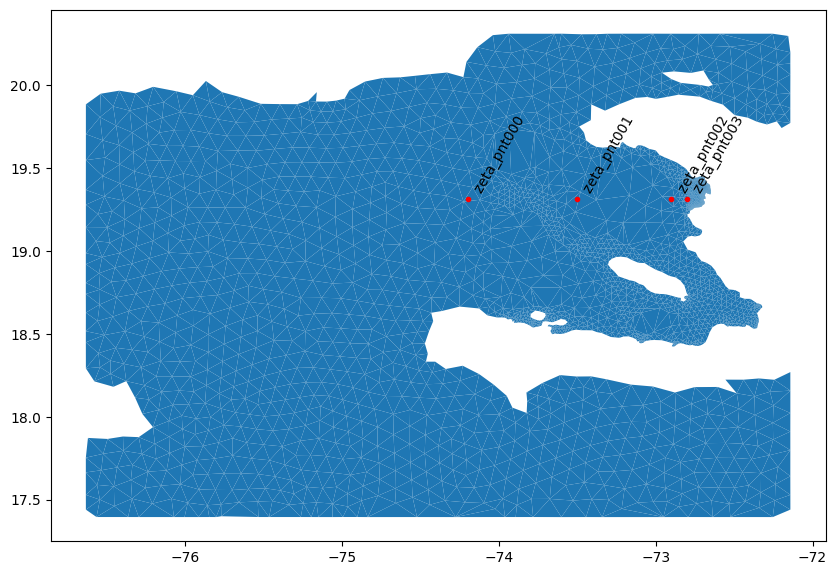

In [19]:
mesh = fort14togdf(root+'/fort.14', epsgIn=4326, epsgOut=4326, fileintype='fort.14')
fig, ax = plt.subplots(figsize = (10,8))
mesh.plot(ax = ax)
ax.scatter(xs, ys, color = 'r', marker = '.')

stations = dfout.columns.tolist()
for i, txt in enumerate(stations):
    ax.annotate('  '+txt, (xs[i], ys[i]), rotation=60)